In [4]:
# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/PCALinear'
pict_results_path = os.environ['PACKAGE_OUTPUT']+'/PCALinear/picts'
files_results_path = os.environ['PACKAGE_OUTPUT']+'/PCALinear/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+
                                  'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'

Time to import all libraries: 2.28881835938e-05 seconds
Time to read data file: 2.0662009716 seconds


In [2]:
# Get data in correct format
from keras.utils import np_utils

# create a full data vector
all_data = {};
all_trgt = {};

for iclass, class_label in enumerate(class_labels):
    for irun in range(len(data[iclass])):
        if len(all_data) == 0:
            all_data = data[iclass][irun]['Signal']
            all_trgt = (iclass)*np.ones(data[iclass][irun]['Signal'].shape[1])
        else:
            all_data = np.append(all_data,data[iclass][irun]['Signal'],axis=1)
            all_trgt = np.append(all_trgt,(iclass)*np.ones(data[iclass][irun]
                                                           ['Signal'].shape[1]),axis=0)

all_data = all_data.transpose()

# turn targets in sparse mode
trgt_sparse = np_utils.to_categorical(all_trgt)

Using Theano backend.
/home/natmourajr/.virtualenvs/sonarsatigny/lib/python2.7/site-packages/keras/utils/np_utils.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = np.zeros((len(y), nb_classes))
/home/natmourajr/.virtualenvs/sonarsatigny/lib/python2.7/site-packages/keras/utils/np_utils.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


In [3]:
# Train Process
from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry(package_name="PreProcessing",analysis_name='PCALinear')

# Create a train information file
n_folds = 2
n_inits = 2
norm = 'mapstd'

train_info = {}
train_info['n_folds'] = n_folds
train_info['norm'] = norm
train_info['n_inits'] = n_inits

train_info_name = result_analysis_path+'/train_info_files'+'/'+date+'_train_info.jbl'
pca_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcas_files.jbl'

from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.decomposition import PCA

CVO = cross_validation.StratifiedKFold(all_trgt, train_info['n_folds'])
CVO = list(CVO)
train_info['CVO'] = CVO

joblib.dump([train_info],train_info_name,compress=9)

n_pcas = all_data.shape[1]
pca = {}
pca_energy = np.zeros([train_info['n_folds'],n_pcas])
bins = np.linspace(0,n_pcas-1,n_pcas)

for ifold in range(train_info['n_folds']):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
    
    pca[ifold] = PCA(n_components=norm_all_data.shape[1])
    pca[ifold].fit(norm_all_data[train_id,:])
    pca_energy[ifold,:] = pca[ifold].explained_variance_/np.sum(pca[ifold].explained_variance_)

joblib.dump([pca,pca_energy],pca_file_name,compress=9)

['/home/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/PreProcessing/PCALinear/output_files/2016_12_08_14_27_28_pcas_files.jbl']

In [4]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="PreProcessing")
print log_entries

{0: {'date': '2016_09_19_19_13_02', 'package': 'PCALinear'}, 1: {'date': '2016_09_21_19_25_31', 'package': 'NLPCA'}, 2: {'date': '2016_09_21_19_25_48', 'package': 'NLPCA'}, 3: {'date': '2016_09_21_20_14_31', 'package': 'NLPCA'}, 4: {'date': '2016_09_21_20_25_54', 'package': 'NLPCA'}, 5: {'date': '2016_09_21_20_26_05', 'package': 'NLPCA'}, 6: {'date': '2016_09_21_20_26_12', 'package': 'NLPCA'}, 7: {'date': '2016_09_21_20_30_53', 'package': 'NLPCA'}, 8: {'date': '2016_09_21_20_35_59', 'package': 'NLPCA'}, 9: {'date': '2016_09_21_20_36_30', 'package': 'NLPCA'}, 10: {'date': '2016_09_21_20_40_38', 'package': 'NLPCA'}, 11: {'date': '2016_09_21_20_56_00', 'package': 'NLPCA'}, 12: {'date': '2016_09_22_20_19_12', 'package': 'PCDIndependent'}, 13: {'date': '2016_09_28_15_09_30', 'package': 'NLPCA'}, 14: {'date': '2016_09_28_15_29_56', 'package': 'NLPCA'}, 15: {'date': '2016_09_28_16_18_29', 'package': 'NLPCA'}, 16: {'date': '2016_09_28_16_48_17', 'package': 'NLPCA'}, 17: {'date': '2016_09_29_01

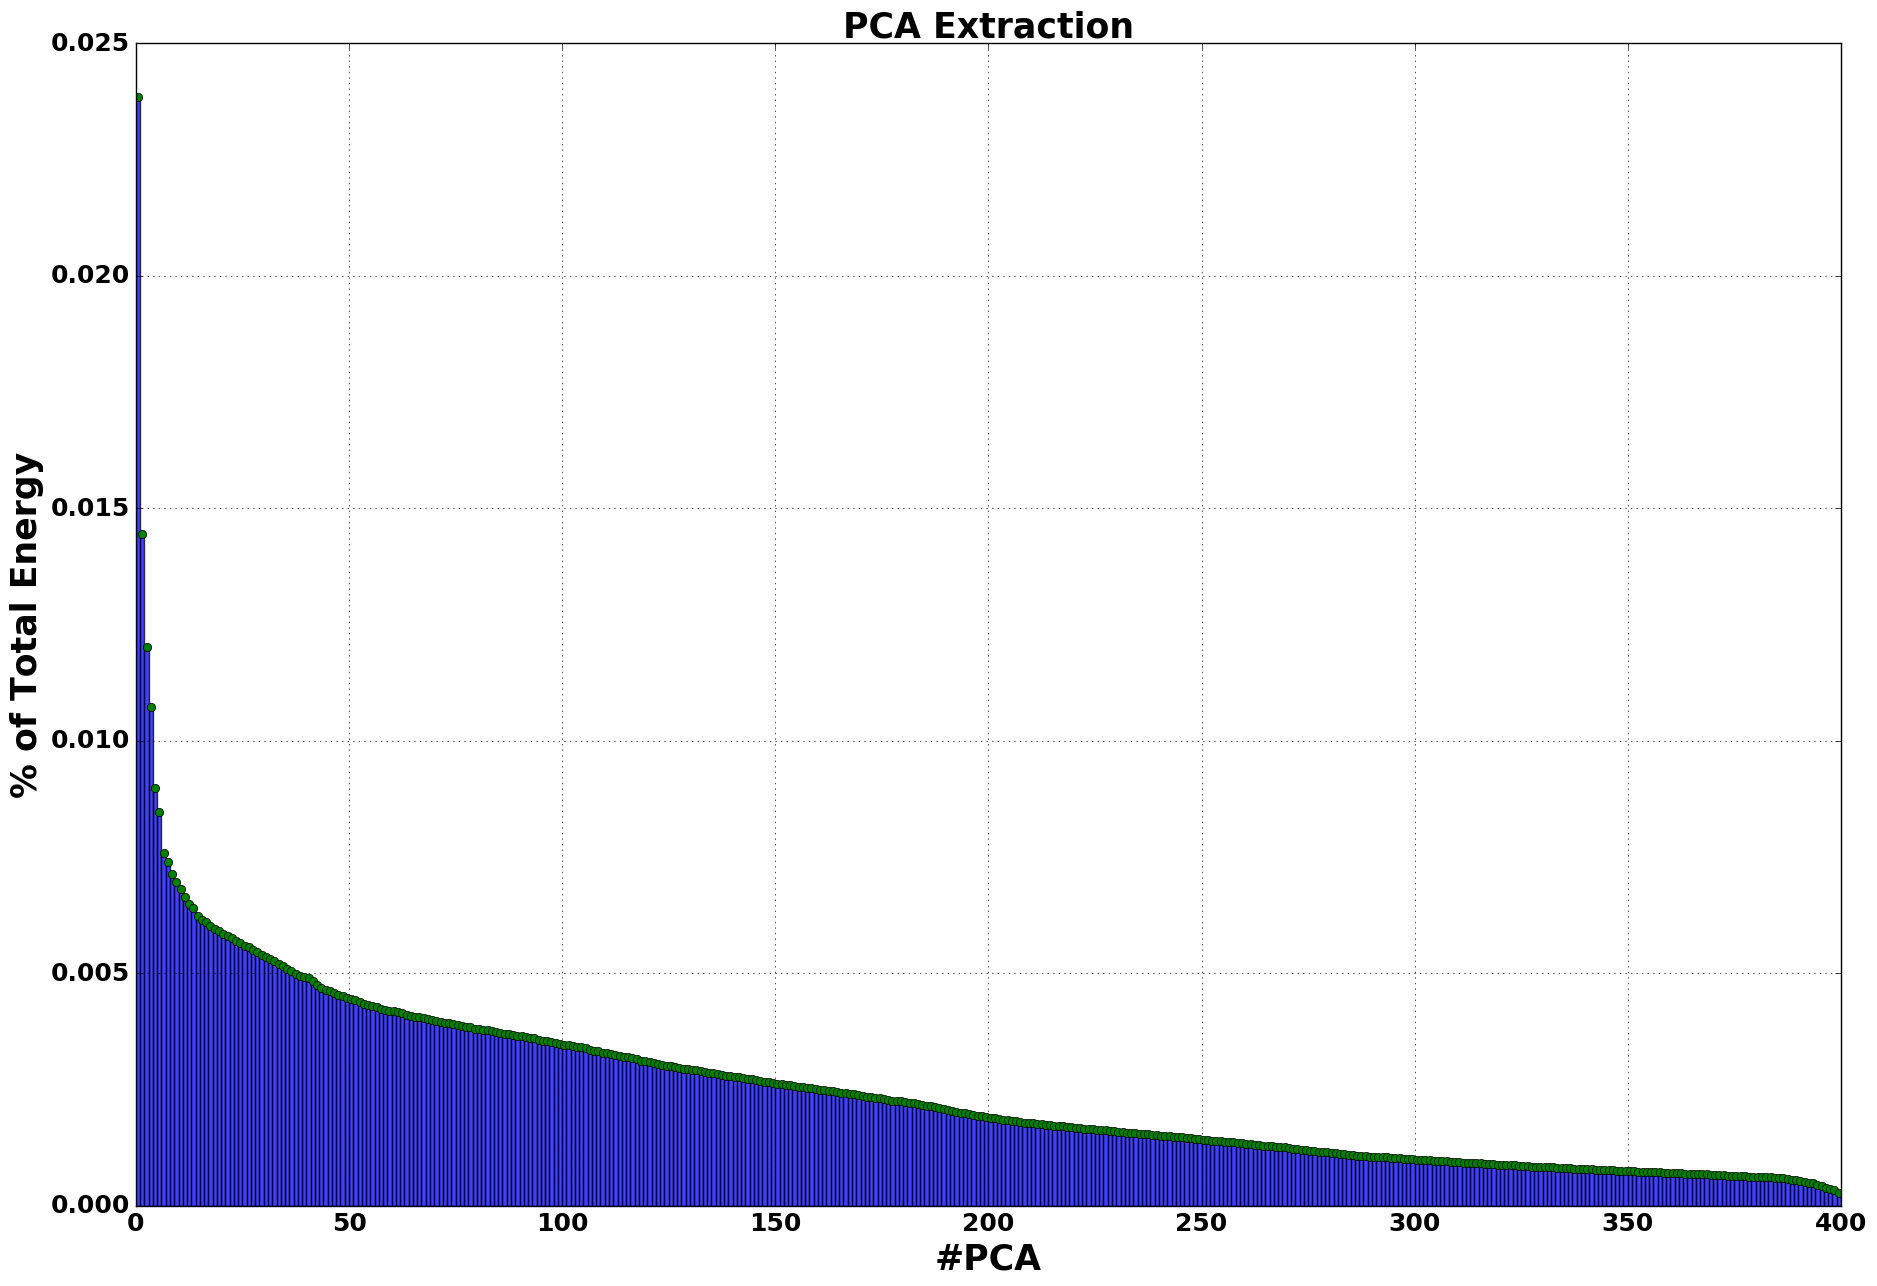

In [5]:
# Analysis Process
# Plot each PCA energy (distribution)
choose_date = '2016_09_19_19_13_02'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

n_pcas = all_data.shape[1]
bins = np.linspace(0,n_pcas-1,n_pcas)

fig, subplot_array = plt.subplots(nrows=1, ncols=1,figsize=(22,15))
plt.bar(bins,np.mean(pca_energy.T,1),
        width=1, yerr=np.var(pca_energy.T,1),
        facecolor='b',alpha=0.75,label='Energy of PCAi')
plt.errorbar(bins+0.5, np.mean(pca_energy.T,1),
             yerr=np.var(pca_energy.T,1),ecolor='r',fmt='o')

plt.grid()
m_fontsize = 25
plt.title('PCA Extraction', fontsize= m_fontsize, fontweight='bold')
plt.ylabel('% of Total Energy', fontsize= m_fontsize, fontweight='bold')
plt.xlabel('#PCA', fontsize= m_fontsize, fontweight='bold')



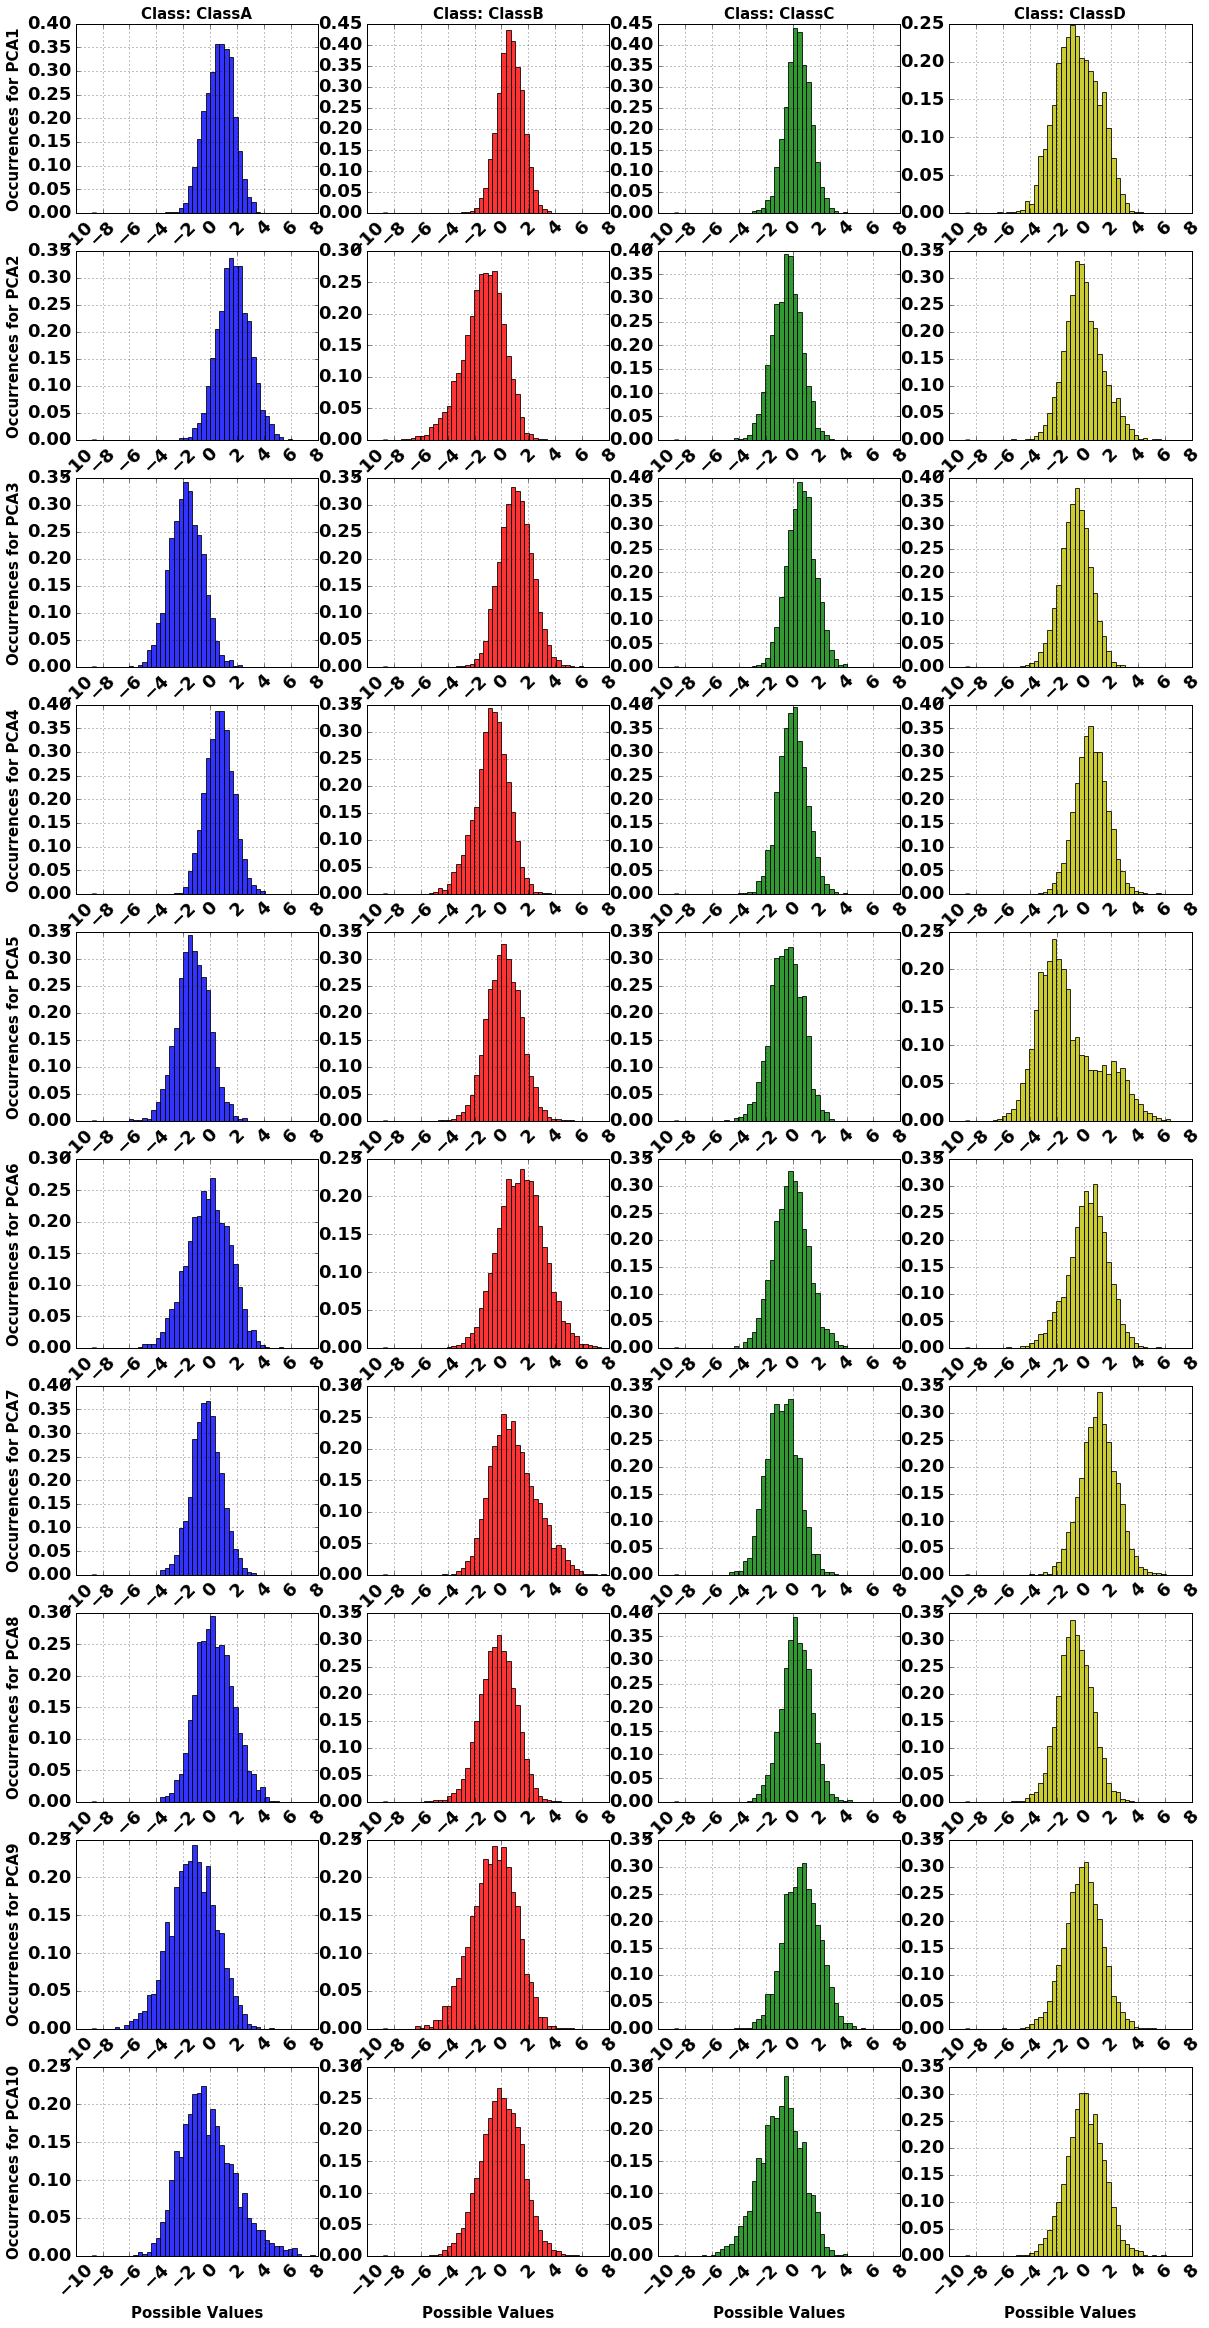

In [129]:
# Analysis Process
# Plot Class Distribution in each PCA

choose_date = '2016_09_01_20_08_11'
choose_fold = 0
number_pca_plot = 10
n_classes = 4

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

n_pcas = all_data.shape[1]
bins = np.linspace(0,n_pcas-1,n_pcas)


fig, ax = plt.subplots(figsize=(20,40),nrows=number_pca_plot, ncols=n_classes)
class_labels=["ClassA", "ClassB", "ClassC","ClassD"]
m_colors = ['b', 'r', 'g', 'y']

n_rows = number_pca_plot
n_columns = n_classes

irow = 0
icolumn = 0

train_id, test_id = train_info['CVO'][choose_fold]
    
# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
norm_all_data = scaler.transform(all_data)
proj_data = pca[choose_fold].transform(norm_all_data)

for ipca in range(number_pca_plot):
    for iclass, class_label in enumerate(class_labels):
        #print 'PCA: %i - Class: %s'%(ipca,iclass)
        plot_data = proj_data[test_id]
        plot_trgt = all_trgt[test_id]
        
        n_bins = np.linspace(plot_data.min(),plot_data.max(),50)
        n, bins, patches = ax[irow,icolumn].hist(plot_data[plot_trgt==iclass,ipca],bins=n_bins,
                                                      fc=m_colors[iclass],
                                                      alpha=0.8, normed=1)
        
        for tick in ax[irow,icolumn].get_xticklabels():
            tick.set_rotation(45)
        ax[irow,icolumn].grid()
        
        if irow == 0:
            ax[irow,icolumn].set_title('Class: %s'%(class_label),
                                  fontweight='bold',fontsize=15)
        if icolumn == 0:
            ax[irow,icolumn].set_ylabel('Occurrences for PCA%i'%(ipca+1),fontweight='bold',fontsize=15)
        if irow == n_rows-1:
            ax[irow,icolumn].set_xlabel('Possible Values',fontweight='bold',fontsize=15)
        
        if icolumn+1 == n_columns:
            icolumn = 0
            irow = irow+1
        else:
            icolumn = icolumn+1

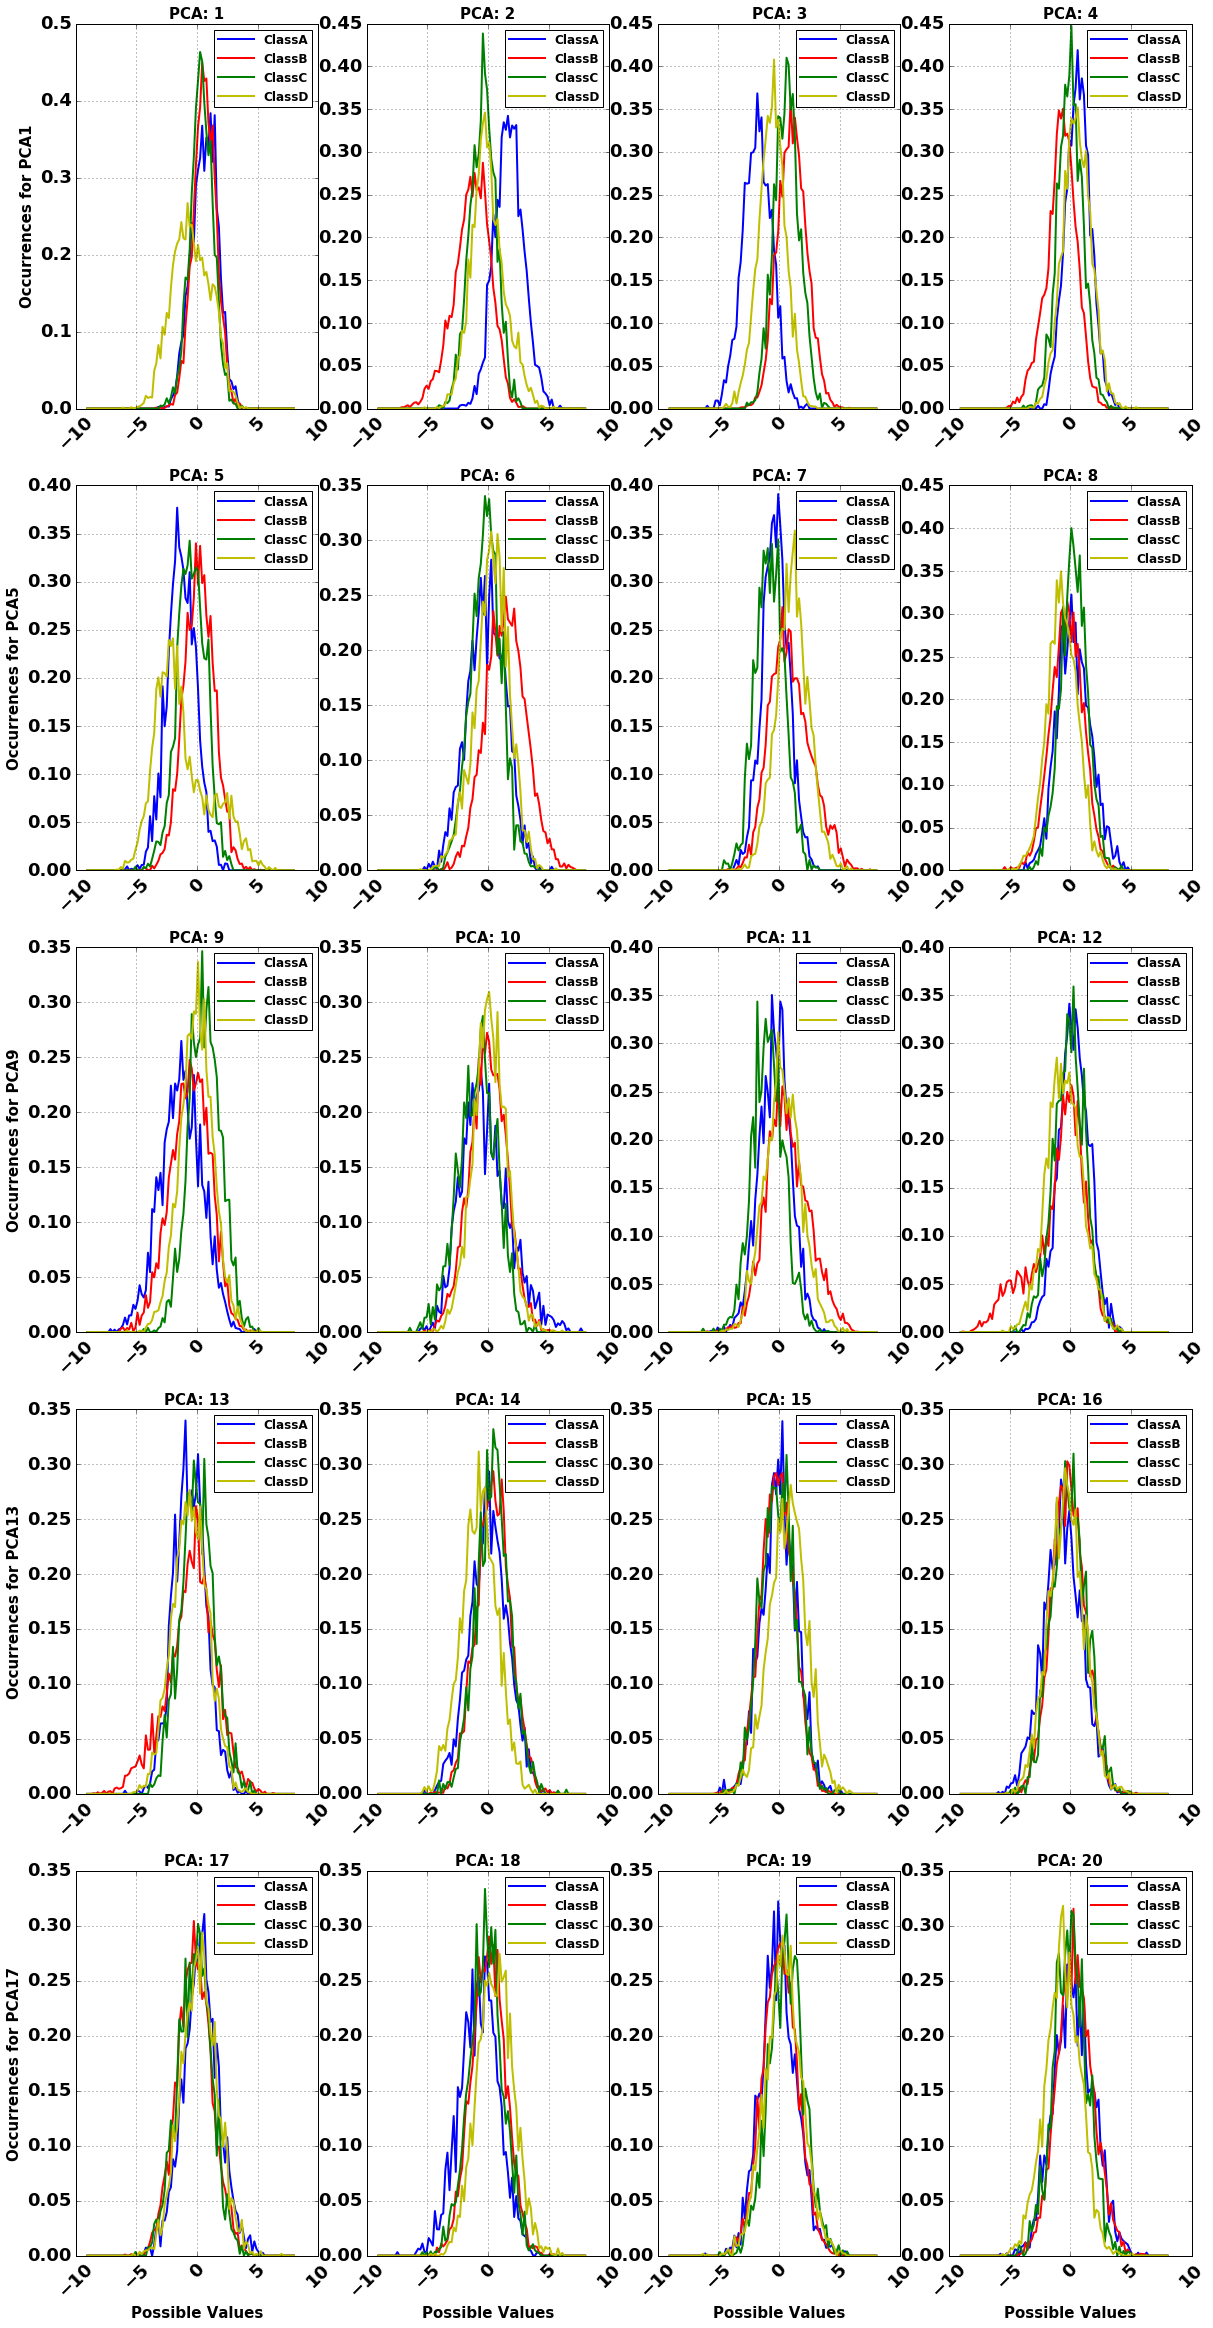

In [122]:
# Analysis Process
# Plot Class Distribution in each PCA

choose_date = '2016_09_01_20_08_11'
choose_fold = 0
number_pca_plot = 20

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

from sklearn.neighbors import KernelDensity
kernel = 'epanechnikov' # other kernels: 'gaussian', 'tophat', 
                    #'epanechnikov', 'exponential', 'linear', 'cosine'

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

n_rows = 5
n_columns = int(np.ceil(float(number_pca_plot)/float(n_rows)))

fig, ax = plt.subplots(figsize=(20,40),nrows=n_rows, ncols=n_columns)
class_labels=["ClassA", "ClassB", "ClassC","ClassD"]
m_colors = ['b', 'r', 'g', 'y']

irow = 0
icolumn = 0

train_id, test_id = train_info['CVO'][choose_fold]
    
# normalize data based in train set
if train_info['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
elif train_info['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
norm_all_data = scaler.transform(all_data)
proj_data = pca[choose_fold].transform(norm_all_data)

for ipca in range(number_pca_plot):
    for iclass, class_label in enumerate(class_labels):
        #print 'PCA: %i - Class: %s'%(ipca,iclass)
        plot_data = proj_data[test_id]
        plot_trgt = all_trgt[test_id]
        
        n_bins = np.linspace(plot_data.min()-.25,plot_data.max()+.25,100)
        kde = KernelDensity(kernel=kernel,algorithm='auto',
                            bandwidth=0.1).fit(plot_data[plot_trgt==iclass,ipca][:,np.newaxis])
        
        log_dens_x = kde.score_samples(n_bins[:, np.newaxis])
        ax[irow,icolumn].plot(n_bins, np.exp(log_dens_x),
                      color=m_colors[iclass],
                      linewidth=2.0,label=class_labels[iclass])
        
    handles, labels = ax[irow,icolumn].get_legend_handles_labels()
    ax[irow,icolumn].legend(handles, labels,loc='best')

    ax[irow,icolumn].set_title('PDFs in PCA %i'%(ipca+1),fontweight='bold',fontsize=15)
    
    for tick in ax[irow,icolumn].get_xticklabels():
        tick.set_rotation(45)
    ax[irow,icolumn].grid()
        

    ax[irow,icolumn].set_title('PCA: %i'%(ipca+1),fontweight='bold',fontsize=15)
    if icolumn == 0:
        ax[irow,icolumn].set_ylabel('Occurrences for PCA%i'%(ipca+1),fontweight='bold',fontsize=15)
    if irow == n_rows-1:
        ax[irow,icolumn].set_xlabel('Possible Values',fontweight='bold',fontsize=15)
        
    if icolumn+1 == n_columns:
        icolumn = 0
        irow = irow+1
    else:
        icolumn = icolumn+1

In [79]:
plot_data[:,ipca][:,np.newaxis].shape

(12923, 1)

([<matplotlib.axis.XTick at 0x123b3e250>,
 <a list of 21 Text xticklabel objects>)

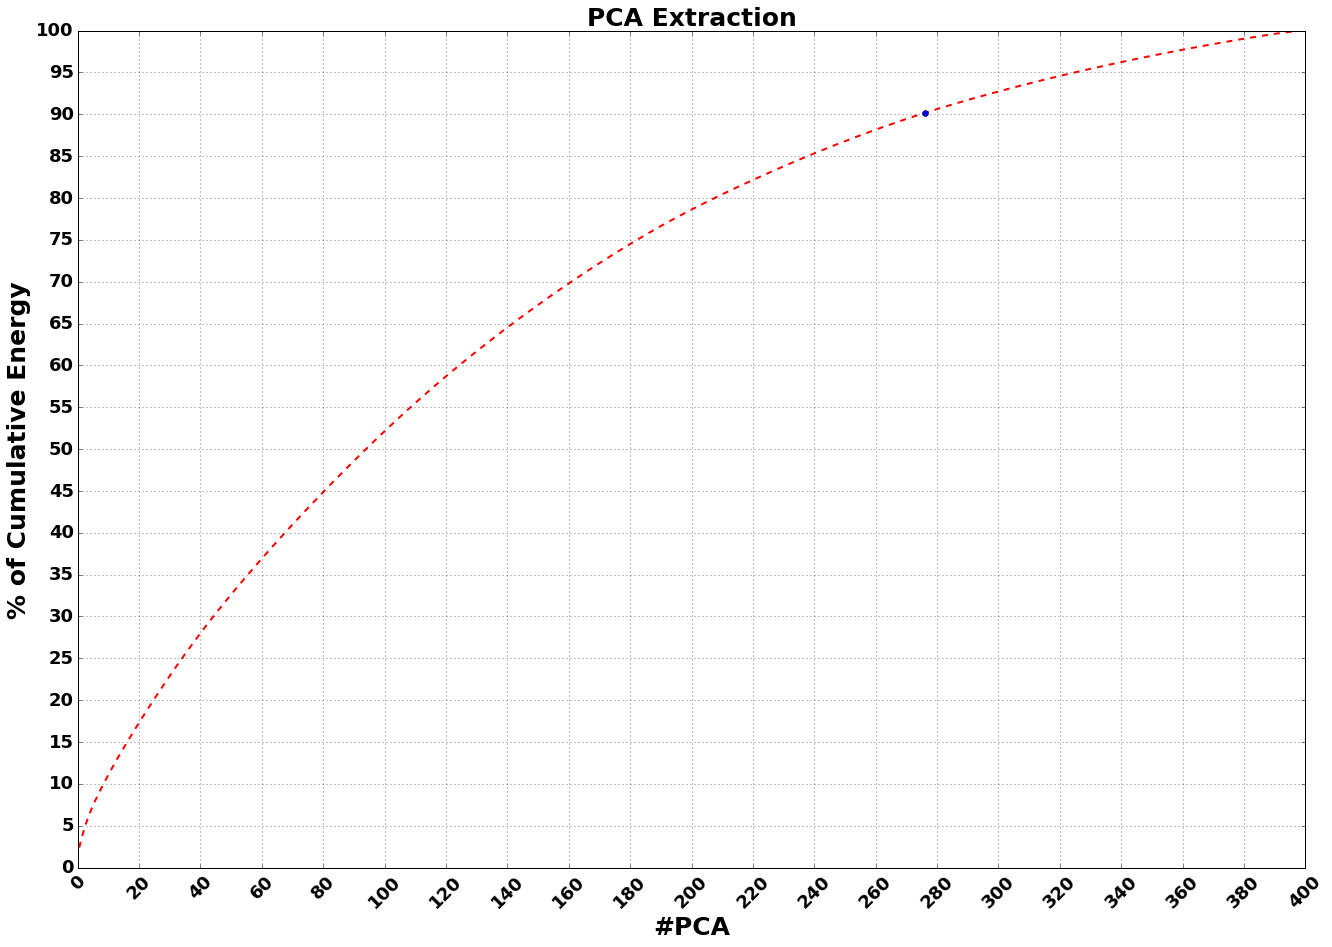

In [197]:
# Analysis Process
# Plot cumulative PCA energy
choose_date = '2016_09_01_20_08_11'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

n_pcas = all_data.shape[1]
bins = np.linspace(0,n_pcas-1,n_pcas)


fig, subplot_array = plt.subplots(nrows=1, ncols=1,figsize=(22,15))
plt.plot(bins+0.5,100.*np.cumsum(np.mean(pca_energy.T,1)),'r--')

for ipca in range(0,n_pcas,1):
    if np.sum(np.mean(pca_energy.T,1)[0:ipca]) > 0.9:
        break
plt.plot(bins[ipca],100.*np.sum(np.mean(pca_energy.T,1)[0:ipca]),'bo')

plt.grid()
m_fontsize = 25
plt.title('PCA Extraction', fontsize= m_fontsize, fontweight='bold')
plt.ylabel('% of Cumulative Energy', fontsize= m_fontsize, fontweight='bold')
plt.xlabel('#PCA', fontsize= m_fontsize, fontweight='bold')

plt.yticks([x for x in range(0,101,5)],[x for x in range(0,101,5)])
plt.xticks([x for x in range(0,401,20)],[x for x in range(0,401,20)],rotation=45)

In [36]:
# Analysis Process

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.layers import Merge
from keras.models import load_model

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# Plot Classification Eff from NN
choose_date = '2016_09_01_20_13_27'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

classifiers = {}

eff = np.zeros([4,train_info['n_folds'],all_data.shape[1]])

for ifold in range(train_info['n_folds']):
        
    classifiers[ifold] = {}
    
    train_id, test_id = train_info['CVO'][ifold]
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
    proj_data = pca[ifold].transform(norm_all_data)
    
    testing_pts = range(0,400,50)
    
    for ipca in testing_pts:       
        if ipca == 0:
            continue
            
        train_data = proj_data[:,0:ipca]
        
        best_init = 0
        best_loss = 999
        for i_init in range(train_info['n_inits']):
            if i_init > 0: # to be fast
                continue
            print ('Processing: Fold %i of %i - PCA %i of %i - Init %i of %i'%(
                    ifold+1,train_info['n_folds'], 
                    ipca, proj_data.shape[1],
                    i_init+1, train_info['n_inits']))
            model = Sequential()
            model.add(Dense(train_data.shape[1],
                            input_dim=train_data.shape[1],
                            init='identity',trainable=False))
            model.add(Activation('linear'))
            model.add(Dense(20, input_dim=train_data.shape[1], init='uniform'))
            model.add(Activation('tanh'))
            model.add(Dense(trgt_sparse.shape[1], init='uniform')) 
            model.add(Activation('tanh'))
            sgd = SGD(lr=0.05, decay=1e-6, momentum=0.7)
            model.compile(loss='mean_squared_error',
                          optimizer=sgd,
                          metrics=['accuracy'])
            earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                            verbose=0, mode='auto')
            # Train model
            init_trn_desc = model.fit(train_data[train_id], trgt_sparse[train_id], 
                                      nb_epoch=100, batch_size=8, 
                                      callbacks=[earlyStopping], 
                                      verbose=0, 
                                      validation_data=(train_data[test_id],
                                                       trgt_sparse[test_id]), 
                                      shuffle=True)
            if np.min(init_trn_desc.history['val_loss']) < best_loss:
                    best_init = i_init
                    best_loss = np.min(init_trn_desc.history['val_loss'])
                    classifiers[ifold][ipca] = model
            
        # save model
        class_file_name = (('%s/output_files'+
                           '/%s_class_files_%i_fold_%i_pca.h5')%
                           (result_analysis_path,choose_date,ifold,ipca))
        classifiers[ifold][ipca].save(class_file_name) 
        
        # get the best output
        output = classifiers[ifold][ipca].predict(train_data)
        all_output = np.argmax(output,axis=1)
        cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
        cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
        for iclass in range(4):
            eff[iclass, ifold, ipca] = cm[iclass,iclass]
        
eff_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_eff_file.jbl'
joblib.dump([eff,testing_pts],eff_file_name,compress=9)

Processing: Fold 1 of 2 - PCA 50 of 400 - Init 1 of 2
Processing: Fold 1 of 2 - PCA 100 of 400 - Init 1 of 2
Processing: Fold 1 of 2 - PCA 150 of 400 - Init 1 of 2
Processing: Fold 1 of 2 - PCA 200 of 400 - Init 1 of 2
Processing: Fold 1 of 2 - PCA 250 of 400 - Init 1 of 2
Processing: Fold 1 of 2 - PCA 300 of 400 - Init 1 of 2
Processing: Fold 1 of 2 - PCA 350 of 400 - Init 1 of 2
Processing: Fold 2 of 2 - PCA 50 of 400 - Init 1 of 2
Processing: Fold 2 of 2 - PCA 100 of 400 - Init 1 of 2
Processing: Fold 2 of 2 - PCA 150 of 400 - Init 1 of 2
Processing: Fold 2 of 2 - PCA 200 of 400 - Init 1 of 2
Processing: Fold 2 of 2 - PCA 250 of 400 - Init 1 of 2
Processing: Fold 2 of 2 - PCA 300 of 400 - Init 1 of 2
Processing: Fold 2 of 2 - PCA 350 of 400 - Init 1 of 2


['/Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/PreProcessing/PCALinear/output_files/2016_09_01_20_13_27_eff_file.jbl']

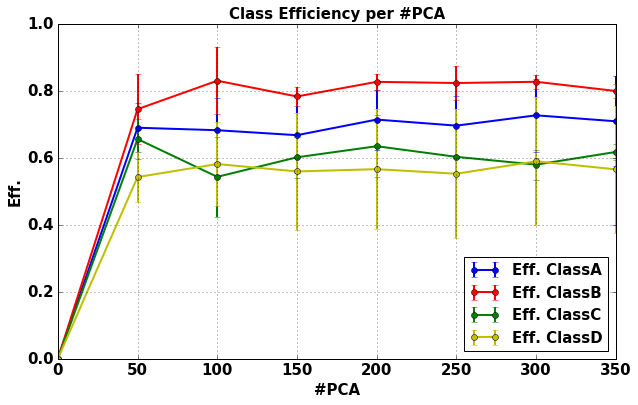

In [37]:
# Analysis Process

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.layers import Merge

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# Plot Classification Eff from NN
choose_date = '2016_09_01_20_13_27'


# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

eff_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_eff_file.jbl'
[eff,testing_pts] = joblib.load(eff_file_name)

import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig = plt.figure(figsize=(10,6))

class_labels=["ClassA", "ClassB", "ClassC","ClassD"]
m_colors = ['b', 'r', 'g', 'y']


for iclass, class_label in enumerate(class_labels):
    plt.errorbar(testing_pts,
                 np.mean(eff[:,:,:],axis=1)[iclass,testing_pts],
                 np.std(eff[:,:,:],axis=1)[iclass,testing_pts],
                 color=m_colors[iclass],linewidth=2.0,
                 label='Eff. %s'%(class_labels[iclass]),
                 fmt='-o')
    
plt.grid()
plt.legend(loc='best')
plt.title('Class Efficiency per #PCA',fontweight='bold',fontsize=15)
plt.xlabel('#PCA',fontweight='bold',fontsize=15)
plt.ylabel('Eff.',fontweight='bold',fontsize=15)

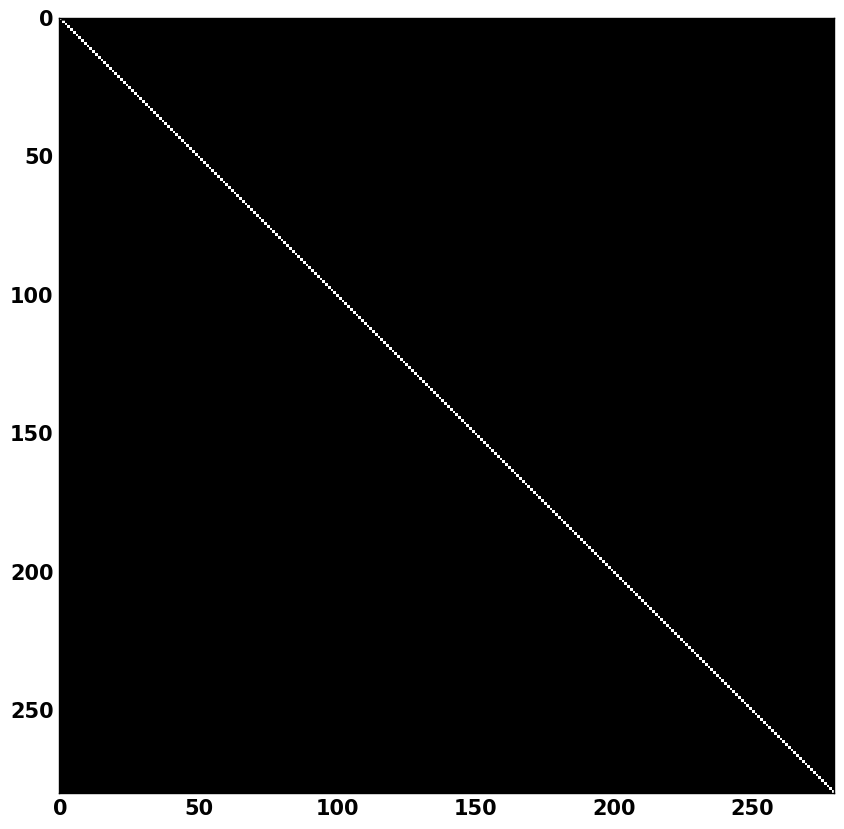

In [22]:
# Analysis Process

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.layers import Merge

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# Plot Classification Eff from NN
choose_date = '2016_09_29_15_34_34'

choose_fold = 0

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

pca_matrix = pca[choose_fold].components_
number_of_pcas = 280

degree_matrix = np.zeros([number_of_pcas,number_of_pcas])

for ipca in range(number_of_pcas):
    for jpca in range(number_of_pcas):
        degree = (np.inner(pca_matrix[ipca].T,pca_matrix[jpca].T)/
                 (np.linalg.norm(pca_matrix[ipca])*
                  np.linalg.norm(pca_matrix[jpca])))
        degree = round(degree.real,4)
        degree = np.arccos(degree)
        degree = np.degrees(degree)
        if degree > 90 and degree < 180:
            degree = degree - 180
        if degree > 180 and degree < 270:
            degree = degree - 180
        
        degree_matrix[ipca,jpca] = np.abs(degree)
        
import matplotlib.pyplot as plt
%matplotlib inline  

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rc('legend',**{'fontsize':15})

plt.rc('font', weight='bold')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im =ax.imshow(degree_matrix, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 90.0))
width, height = degree_matrix.shape



In [18]:
pca[0].components_.shape

(400, 400)